## Benchmarking C Foreign Function Performance

I wrote a naive 2D matrix multiplication algorithm using four approaches: pure Python, Python compiled using Numba's JIT compiler, and two C functions called using `ctypes`.  These four approaches are compared across multiple matrix dimensions to demonstrate the speed-up obtained using C code.  Numpy matrix multiplication is also included in the comparison to provide a reference to a highly optimized linear algebra library.  The naive implementations are O(n<sup>3</sup>) algorithms and do not utilize any parallelism or code vectorization.

The two C functions are defined in the next cell.  The only difference between them is the order of the nested FOR loops.  The Python, Numba, and first C implementations use an i-j-k loop order.  The second C function swaps the j and k FOR loops to i-k-j order, and should benefit from spatial locality as explained in this [Wikipedia article](https://en.wikipedia.org/wiki/Locality_of_reference#Matrix_multiplication).  

In [1]:
# Standard system imports
import ctypes
import pathlib

# Related third party imports
from numba import njit
import numpy as np

c_lib = ctypes.CDLL("../C/lib/libbenchmarking.so") # Location of C shared library

# C function implemented with i-j-k loop order.
mat_mult = c_lib.mat_mult
mat_mult.argtypes = [ctypes.c_int, ctypes.c_int, ctypes.c_int,
                  ctypes.POINTER(ctypes.c_double),
                  ctypes.POINTER(ctypes.c_double),
                  ctypes.POINTER(ctypes.c_double)]
mat_mult.restype = None  # C function returns void

# C function implemented with i-k-j loop order.
mat_mult_ikj = c_lib.mat_mult_ikj
mat_mult_ikj.argtypes = [ctypes.c_int, ctypes.c_int, ctypes.c_int,
                  ctypes.POINTER(ctypes.c_double),
                  ctypes.POINTER(ctypes.c_double),
                  ctypes.POINTER(ctypes.c_double)]
mat_mult_ikj.restype = None  # C function returns void

In [2]:
def create_mats(out1, inner, out2, rng):
    """Return 2D Numpy arrays with C double datatype as well as pointers to the arrays."""
    mat1 = rng.random((out1, inner), dtype=np.double)
    mat2 = rng.random((inner, out2), dtype=np.double)
    mat3 = np.zeros((out1, out2), dtype=np.double)

    mat1_ptr = mat1.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    mat2_ptr = mat2.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    mat3_ptr = mat3.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    
    return mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr
    
def c_mat_mult(out1, inner, out2, mat1_ptr, mat2_ptr, mat3_ptr):
    """Naive matrix multiplication implementation using a C extension."""
    mat_mult(out1, out2, inner, mat1_ptr, mat2_ptr, mat3_ptr)
    
def c_mat_mult_ikj(out1, inner, out2, mat1_ptr, mat2_ptr, mat3_ptr):
    """Naive matrix multiplication implementation using a C extension.
    
    FOR loops re-ordered to reduce cache misses (i-k-j order).
    """
    mat_mult_ikj(out1, out2, inner, mat1_ptr, mat2_ptr, mat3_ptr)
    
def np_mat_mult(mat1, mat2):
    """Matrix multiplication implemented using Numpy."""
    return mat1 @ mat2
    
    
def python_mat_mult(out1, inner, out2, mat1, mat2, mat3):
    """Naive matrix multiplication implementation using Python."""
    for i in range(out1):
        for j in range (out2):
            mat3[i][j] = mat1[i][0] * mat2[0][j]
            for k in range(1, inner):
                mat3[i][j] += mat1[i][k] * mat2[k][j]
    return mat3
        
@njit
def numba_mat_mult(out1, inner, out2, mat1, mat2, mat3):
    """Naive matrix multiplication implementation using Numba's JIT compiler.
    
    Numba apparently cannot accept pointers to doubles.
    """
    for i in range(out1):
        for j in range (out2):
            mat3[i][j] = mat1[i][0] * mat2[0][j]
            for k in range(1, inner):
                mat3[i][j] += mat1[i][k] * mat2[k][j]
    return mat3

In [3]:
# Generate same set of random matrices using seed
mat_dim = 100
out1 = mat_dim
inner = mat_dim
out2 = mat_dim

def generate_matrices(mat_dim):
    rng = np.random.default_rng(12345)
    out1 = mat_dim
    inner = mat_dim
    out2 = mat_dim
    mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = create_mats(out1, inner, out2, rng)
    return mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr

In [4]:
# Verify all methods return same results
mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
python_result = python_mat_mult(out1, inner, out2, mat1, mat2, mat3)

mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
numpy_result = np_mat_mult(mat1, mat2)

mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
numba_result = numba_mat_mult(out1, inner, out2, mat1, mat2, mat3) # JIT compiler will compile code on first call to function

mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
c_mat_mult(out1, inner, out2, mat1_ptr, mat2_ptr, mat3_ptr)
c_result = mat3

mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
c_mat_mult_ikj(out1, inner, out2, mat1_ptr, mat2_ptr, mat3_ptr)
c_result_ikj = mat3

# Compare results; should be approximately equal within some tolerance
np.testing.assert_allclose(python_result, numpy_result, rtol=0, atol=1e-10)
np.testing.assert_allclose(python_result, numba_result, rtol=0, atol=1e-10)
np.testing.assert_allclose(python_result, c_result, rtol=0, atol=1e-10)
np.testing.assert_allclose(python_result, c_result_ikj, rtol=0, atol=1e-10)

In [5]:
# Use timeit to compare the approaches
python_times = []
numpy_times = []
numba_times = []
c_times = []
c_times_ikj = []
mat_dims = np.array([10, 50, 100, 200])

for mat_dim in mat_dims:
    mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
    run_time = %timeit -o python_mat_mult(mat_dim, mat_dim, mat_dim, mat1, mat2, mat3)
    python_times.append(run_time)
    run_time = %timeit -o np_mat_mult(mat1, mat2)
    numpy_times.append(run_time)
    run_time = %timeit -o numba_mat_mult(mat_dim, mat_dim, mat_dim, mat1, mat2, mat3)
    numba_times.append(run_time)
    run_time = %timeit -o c_mat_mult(mat_dim, mat_dim, mat_dim, mat1_ptr, mat2_ptr, mat3_ptr)
    c_times.append(run_time)
    run_time = %timeit -o c_mat_mult_ikj(mat_dim, mat_dim, mat_dim, mat1_ptr, mat2_ptr, mat3_ptr)
    c_times_ikj.append(run_time)

698 µs ± 24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.47 µs ± 32.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
2.48 µs ± 9.67 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.95 µs ± 25.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.92 µs ± 9.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
82.6 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.34 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
184 µs ± 5.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
99.7 µs ± 456 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
48.3 µs ± 292 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
656 ms ± 5.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.9 µs ± 922 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.45 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
985 µs ± 5.4 µs per loop (mean ± std. dev. of 7 ru

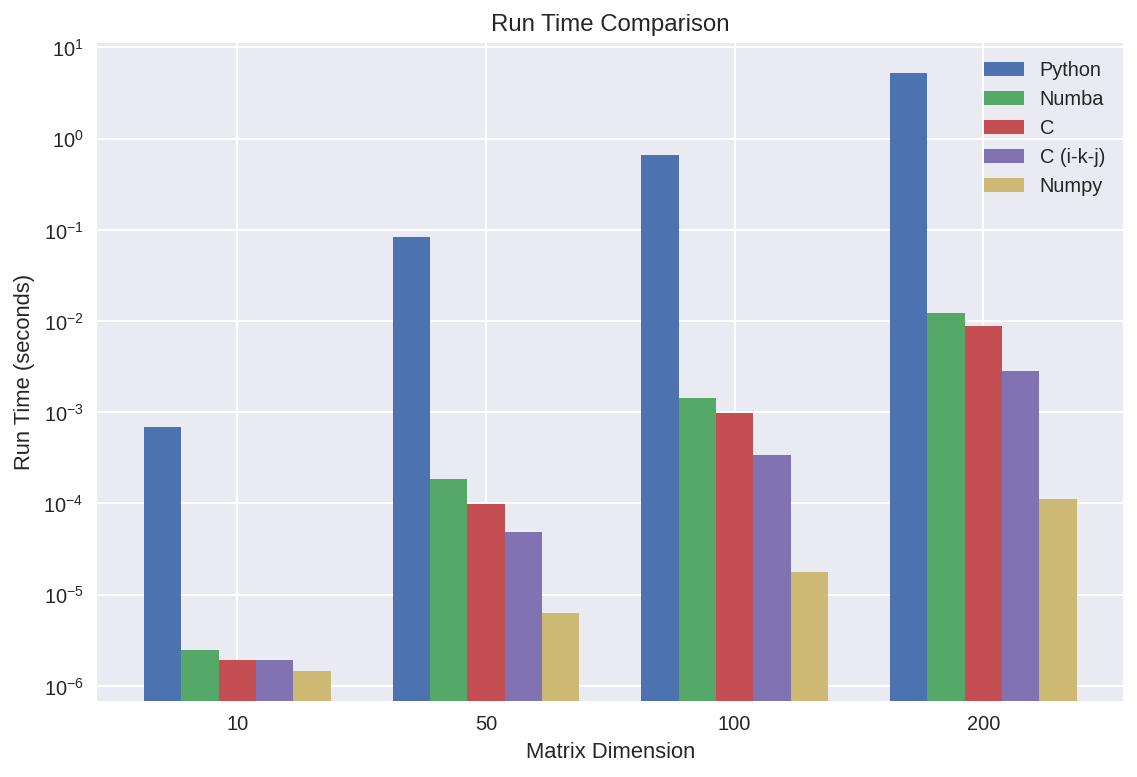

In [7]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn')

# Build the plot
bar_width = 0.15
x_spacing = np.arange(len(mat_dims))
fig, ax = plt.subplots(dpi=72*2)
ax.bar(x_spacing - bar_width*2.0, [x.average for x in python_times], bar_width, label="Python")
ax.bar(x_spacing - bar_width*1.0, [x.average for x in numba_times], bar_width, label="Numba")
ax.bar(x_spacing + bar_width*0.0, [x.average for x in c_times], bar_width, label="C")
ax.bar(x_spacing + bar_width*1.0, [x.average for x in c_times_ikj], bar_width, label="C (i-k-j)")
ax.bar(x_spacing + bar_width*2.0, [x.average for x in numpy_times], bar_width, label="Numpy")

# Configure plot
ax.set_xlabel('Matrix Dimension')
ax.set_xticks(x_spacing)
ax.set_xticklabels(mat_dims)
ax.set_ylabel('Run Time (seconds)')
ax.set_yscale('log')
ax.set_title('Run Time Comparison')
plt.tight_layout()
plt.legend()
plt.show()

## Discussion

The above chart demonstrates that pure Python code is the slowest of the approaches as expected, with Numba and the C code approaching a roughly 3 orders of magnitude speed-up in comparison.  The highly optimized Numpy library is the fastest of the approaches, and is between 1 and 2 orders of magnitude faster than Numba and C.  Numpy uses either Intel MKL or OpenBLAS accelerated linear algebra libraries, and blows my simple nested FOR loop implementation out of the water.

The Numba code's run time is consistently about 50% longer than the equivalent C code run time with larger matrices.  This is still pretty good compared to pure Python code, and raises the question of whether the C foreign function approach should be discarded: after all, Numba allows the developer to stick to writing Python code and only requires a simple function decorator to implement the JIT compiler.  

However, Numba is quite limited in what Python code it will accept and finicky about how that Python code is written.  Numba supports a subset of the standard Python library as well as most Numpy functionality, but chokes on everything else.  Using Numba might be a good first choice if working around all of its limitations doesn't become too tedious.  Otherwise, one might as well just write C code.  The superior performance of C over Numba will also become significant for large computation-intensive problems.

Finally, the version of the C code with re-ordered FOR loops (i-k-j) consistently outperforms the poorly-designed C code by a factor of 3 with large matrices!  This demonstrates that the cache misses really do become a significant drag on performance.